In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

## EDA

In [2]:
movies = pd.read_csv("C:/Users/2023/Desktop/โฟลเดอร์ใหม่/20m movies/movie.csv")
ratings = pd.read_csv("C:/Users/2023/Desktop/โฟลเดอร์ใหม่/20m movies/rating.csv")

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


In [7]:
print(movies.isnull().sum())

movieId    0
title      0
genres     0
dtype: int64


In [8]:
print(ratings.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [9]:
#movies
movies['genres_list'] = movies['genres'].apply(lambda x: x.split('|'))
all_genres = movies['genres_list'].explode()

print(all_genres.value_counts())

genres_list
Drama                 13344
Comedy                 8374
Thriller               4178
Romance                4127
Action                 3520
Crime                  2939
Horror                 2611
Documentary            2471
Adventure              2329
Sci-Fi                 1743
Mystery                1514
Fantasy                1412
War                    1194
Children               1139
Musical                1036
Animation              1027
Western                 676
Film-Noir               330
(no genres listed)      246
IMAX                    196
Name: count, dtype: int64


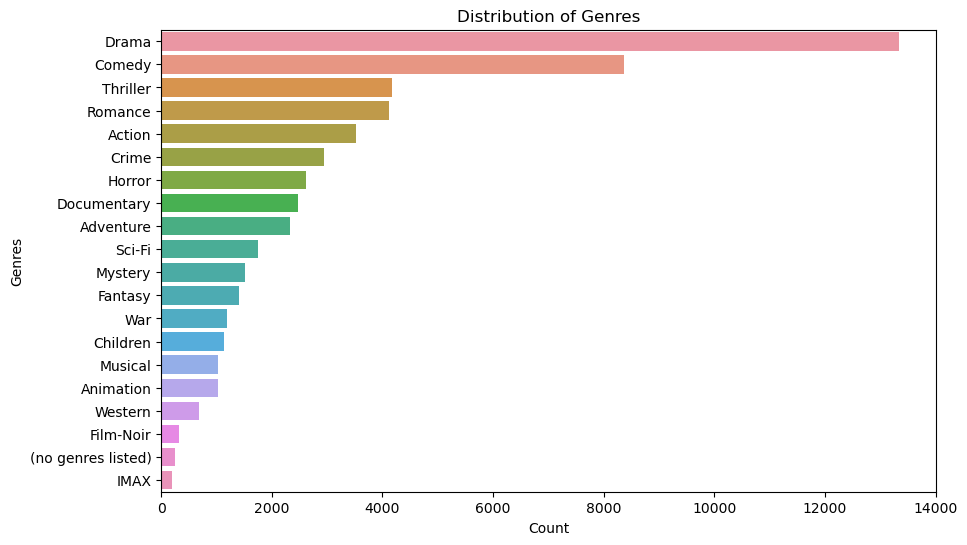

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(y=all_genres, order=all_genres.value_counts().index)
plt.title("Distribution of Genres")
plt.xlabel("Count")
plt.ylabel("Genres")
plt.show()

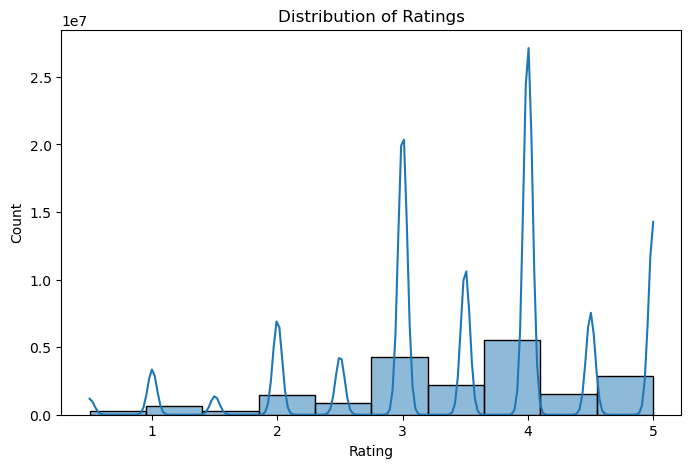

In [11]:
#rating
plt.figure(figsize=(8,5))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [12]:
# นับจำนวนให้คะแนน
rating_count_per_movie = ratings.groupby('movieId')['rating'].count().reset_index()
rating_count_per_movie.columns = ['movieId', 'count']

# คำนวณผลรวมของคะแนน
rating_sum_per_movie = ratings.groupby('movieId')['rating'].sum().reset_index()
rating_sum_per_movie.columns = ['movieId', 'total_rating']

# รวมข้อมูลจำนวนให้คะแนนและผลรวมของคะแนน
movie_rating_counts = pd.merge(movies, rating_count_per_movie, on='movieId')
movie_rating_counts = pd.merge(movie_rating_counts, rating_sum_per_movie, on='movieId')

In [13]:
top_rated_movies = movie_rating_counts.nlargest(10, 'total_rating')

print("\nTop 10 Most Rated Movies:")
top_rated_movies[['movieId', 'title', 'count', 'total_rating']]


Top 10 Most Rated Movies:


,movieId,title,count,total_rating
315,318,"Shawshank Redemption, The (1994)",63366,281788.0
293,296,Pulp Fiction (1994),67310,280967.5
352,356,Forrest Gump (1994),66172,266607.0
587,593,"Silence of the Lambs, The (1991)",63299,264403.5
257,260,Star Wars: Episode IV - A New Hope (1977),54502,228400.0
476,480,Jurassic Park (1993),59715,218840.0
108,110,Braveheart (1995),53769,217363.0
523,527,Schindler's List (1993),50054,215741.5
2486,2571,"Matrix, The (1999)",51334,214945.0
583,589,Terminator 2: Judgment Day (1991),52244,205421.0


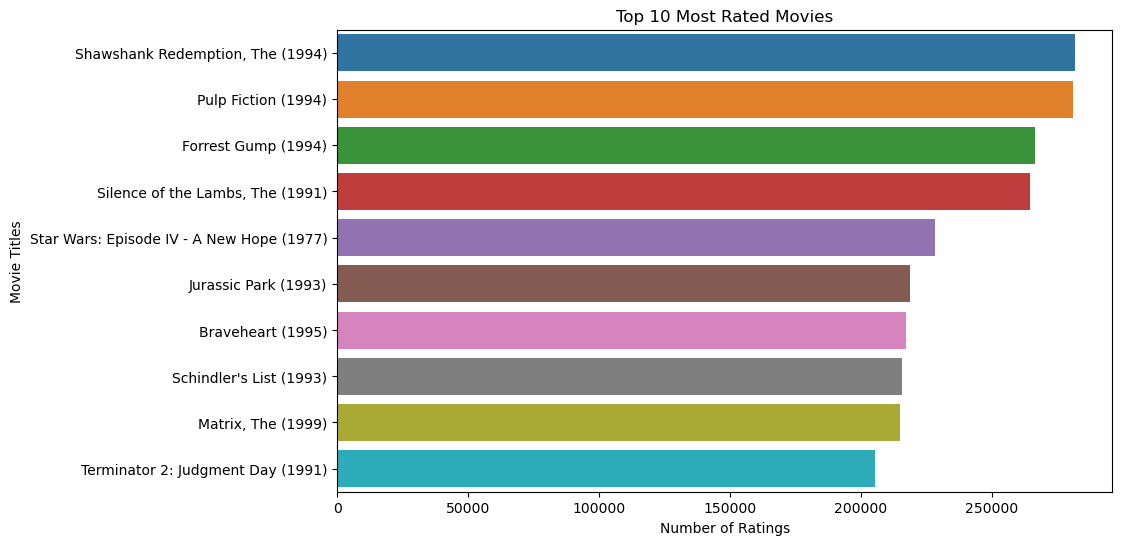

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(x='total_rating', y='title', data=top_rated_movies)
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Titles")
plt.show()

## Prepare dataset

In [15]:
user_ids = ratings['userId'].unique().tolist() 
movie_ids = ratings['movieId'].unique().tolist()

In [16]:
# สร้าง mapping ระหว่าง user และ movie #### เพิ่ม index ให้ userId และ movieId  ไว้เข้า model
user_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_to_index = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

In [17]:
# แปลง user และ movie ids เป็น indices ##### อข้อมูลสุดท้ายจะ = ข้อมูลผู้ใช้แต่ละคน ว่าเคยให้คะแนนเรื่องอะไรบ้าง
ratings['userId'] = ratings['userId'].map(user_to_index)
ratings['movieId'] = ratings['movieId'].map(movie_to_index)

In [18]:
ratings

,userId,movieId,rating,timestamp
0,0,0,3.5,2005-04-02 23:53:47
1,0,1,3.5,2005-04-02 23:31:16
2,0,2,3.5,2005-04-02 23:33:39
3,0,3,3.5,2005-04-02 23:32:07
4,0,4,3.5,2005-04-02 23:29:40
...,...,...,...,...
20000258,138492,1814,4.5,2009-11-13 15:42:00
20000259,138492,1037,4.5,2009-12-03 18:31:48
20000260,138492,3950,3.0,2009-12-07 18:10:57
20000261,138492,1818,5.0,2009-11-13 15:42:24


In [19]:
ratings[ratings['userId'] == 0]

,userId,movieId,rating,timestamp
0,0,0,3.5,2005-04-02 23:53:47
1,0,1,3.5,2005-04-02 23:31:16
2,0,2,3.5,2005-04-02 23:33:39
3,0,3,3.5,2005-04-02 23:32:07
4,0,4,3.5,2005-04-02 23:29:40
...,...,...,...,...
170,0,170,5.0,2004-09-10 03:13:47
171,0,171,4.5,2005-04-02 23:44:53
172,0,172,3.5,2005-04-02 23:33:15
173,0,173,4.0,2005-04-02 23:47:09


In [20]:
train_data, temp_data = train_test_split(ratings, test_size=0.2, random_state=42)

validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)



In [21]:
# สร้างโมเดล Matrix Factorization โดยใช้ Embedding Layers
n_users = len(user_ids)
n_movies = len(movie_ids)
n_factors = 50  

In [22]:
n_users

138493

In [23]:
n_movies

26744

In [24]:
# User Embedding Layer
user_input = layers.Input(shape=(1,), name='user_input')
user_embedding = layers.Embedding(input_dim=n_users, output_dim=n_factors, name='user_embedding')(user_input)   

user_vec = layers.Flatten()(user_embedding)                                     
    

In [25]:
# Movie Embedding Layer เ
movie_input = layers.Input(shape=(1,), name='movie_input')
movie_embedding = layers.Embedding(input_dim=n_movies, output_dim=n_factors, name='movie_embedding')(movie_input)
movie_vec = layers.Flatten()(movie_embedding)

In [27]:
# คำนวณ dot product ของ latent factors (MF)
dot_product = layers.Dot(axes=1)([user_vec, movie_vec])  

## model

In [30]:
# สร้างโมเดล 
x = layers.Dense(128, activation='relu')(dot_product) 
x = layers.Dropout(0.3)(x) 
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)

output = layers.Dense(1)(x) #

model = Model([user_input, movie_input], output)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [36]:
# เทรนโมเดล
history = model.fit(
    [train_data['userId'], train_data['movieId']], #input data 
    train_data['rating'], #target data
    validation_data=([validation_data['userId'], validation_data['movieId']],  # input data 
                      validation_data['rating']),
    epochs=10,
    batch_size=32
)

Epoch 1/10
500007/500007 ━━━━━━━━━━━━━━━━━━━━ 45708s 91ms/step - loss: 1.0376 - val_loss: 0.9486
Epoch 2/10
500007/500007 ━━━━━━━━━━━━━━━━━━━━ 45752s 91ms/step - loss: 0.8892 - val_loss: 0.8810
Epoch 3/10
500007/500007 ━━━━━━━━━━━━━━━━━━━━ 45976s 92ms/step - loss: 0.8063 - val_loss: 0.8350
Epoch 4/10
500007/500007 ━━━━━━━━━━━━━━━━━━━━ 46093s 92ms/step - loss: 0.7429 - val_loss: 0.8033
Epoch 5/10
500007/500007 ━━━━━━━━━━━━━━━━━━━━ 46316s 93ms/step - loss: 0.6902 - val_loss: 0.8121
Epoch 6/10
500007/500007 ━━━━━━━━━━━━━━━━━━━━ 46258s 93ms/step - loss: 0.6495 - val_loss: 0.8352
Epoch 7/10
500007/500007 ━━━━━━━━━━━━━━━━━━━━ 46021s 92ms/step - loss: 0.6191 - val_loss: 0.8014
Epoch 8/10
500007/500007 ━━━━━━━━━━━━━━━━━━━━ 46221s 92ms/step - loss: 0.5951 - val_loss: 0.8247
Epoch 9/10
500007/500007 ━━━━━━━━━━━━━━━━━━━━ 46181s 92ms/step - loss: 0.5768 - val_loss: 0.8286
Epoch 10/10
500007/500007 ━━━━━━━━━━━━━━━━━━━━ 46395s 93ms/step - loss: 0.5617 - val_loss: 0.8235


## Evaluate

In [37]:
predictions = model.predict([test_data['userId'], test_data['movieId']])


62501/62501 ━━━━━━━━━━━━━━━━━━━━ 127s 2ms/step


In [38]:
predictions

array([[3.654974 ],
       [3.1204758],
       [2.7045305],
       ...,
       [2.2929792],
       [2.960934 ],
       [2.732621 ]], dtype=float32)

In [39]:
num_rows = predictions.shape[0]
print(num_rows)

2000027


In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [41]:
mse = mean_squared_error(test_data['rating'], predictions)
mae = mean_absolute_error(test_data['rating'], predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.82372142346303
Mean Absolute Error (MAE): 0.7184916124254958


In [42]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report

In [43]:
#Thresholding: เพื่อแบ่งคะแนนออกเป็นสองกลุ่ม เช่น คะแนนสูงกว่าค่ากลาง(เช่น 3.5 ขึ้นไป) เป็น "ชอบ" และต่ำกว่าค่านั้นเป็น "ไม่ชอบ"  
threshold = 3.5
predicted_labels = (predictions >= threshold).astype(int)  
true_labels = (test_data['rating'] >= threshold).astype(int)

In [44]:
report = classification_report(true_labels, predicted_labels, target_names=["Not Liked", "Liked"])
print(report)

              precision    recall  f1-score   support

   Not Liked       0.54      0.86      0.67    780678
       Liked       0.86      0.53      0.66   1219349

    accuracy                           0.66   2000027
   macro avg       0.70      0.70      0.66   2000027
weighted avg       0.73      0.66      0.66   2000027



## Test

In [45]:
movies = movies[['movieId', 'title', 'genres']]
test_data_original = test_data[['userId', 'movieId', 'rating']]



user_id = 1  test_with_movies = pd.merge(test_data_original, movies, on='movieId', how='left')
user_test_data = test_with_movies[test_with_movies['userId'] == user_id]


user_test_data

,userId,movieId,rating,title,genres
301814,1,181,3.0,Mighty Morphin Power Rangers: The Movie (1995),Action|Children
541054,1,198,2.0,Strange Days (1995),Action|Crime|Drama|Mystery|Sci-Fi|Thriller
1003037,1,188,5.0,"Prophecy, The (1995)",Fantasy|Horror|Mystery
1146292,1,208,4.0,Waterworld (1995),Action|Adventure|Sci-Fi
1364375,1,176,5.0,Living in Oblivion (1995),Comedy
1470348,1,192,4.0,"Show, The (1995)",Documentary
1490801,1,195,2.0,Something to Talk About (1995),Comedy|Drama|Romance
1715211,1,224,5.0,Don Juan DeMarco (1995),Comedy|Drama|Romance
1732323,1,221,4.0,NaN,NaN


In [46]:

# กรองข้อมูลของผู้ใช้นั้นจาก test_data
user_test_data = test_data[test_data['userId'] == user_id]

# นำ userId และ movieId ของผู้ใช้คนนี้มาเพื่อทำนายคะแนน
user_predictions = model.predict([user_test_data['userId'], user_test_data['movieId']])

# สร้าง DataFrame แสดงผลการทำนายพร้อมกับ movieId
user_results = pd.DataFrame({
    'movieId': user_test_data['movieId'],
    'predicted_rating': user_predictions.flatten()  # แปลงเป็น array 1 มิติ # ratting
})

# แสดงผลลัพธ์
print(f"Predicted ratings for user {user_id}:")
user_results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Predicted ratings for user 1:


,movieId,predicted_rating
182,181,3.859525
206,198,2.292979
196,188,3.258206
217,208,2.674990
176,176,3.514862
200,192,2.999174
203,195,2.786792
233,224,3.548479
230,221,3.888395


In [47]:
all_movie_ids = set(movie_to_index.values())  # หนังทั้งหมด
watched_movie_ids = set(user_test_data['movieId'])  # หนังที่ผู้ใช้ดูแล้ว
unwatched_movie_ids = list(all_movie_ids - watched_movie_ids)  # หนังที่ยังไม่ได้ดู

# สร้าง DataFrame สำหรับหนังที่ยังไม่ได้ดู
unwatched_data = pd.DataFrame({
    'userId': [user_id] * len(unwatched_movie_ids), 
    'movieId': unwatched_movie_ids
})

# ทำนายคะแนนสำหรับหนังที่ผู้ใช้ยังไม่ได้ดู
unwatched_predictions = model.predict([unwatched_data['userId'], unwatched_data['movieId']])

# สร้าง DataFrame สำหรับผลลัพธ์การทำนาย
unwatched_results = pd.DataFrame({
    'movieId': unwatched_data['movieId'],
    'predicted_rating': unwatched_predictions.flatten()  
})

unwatched_results = unwatched_results.merge(movies[['movieId', 'title', 'genres']], on='movieId')

# เรียงลำดับหนังที่แนะนำจากคะแนนสูงสุดไปต่ำสุด
unwatched_results = unwatched_results.sort_values(by='predicted_rating', ascending=False)


print(f"Recommended movies for user {user_id}:")
unwatched_results.head(10)

836/836 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Recommended movies for user 1:


,movieId,predicted_rating,title,genres
129,131,4.377719,Frankie Starlight (1995),Drama|Romance
30,31,4.319242,Dangerous Minds (1995),Drama
140,142,4.318406,Shadows (Cienie) (1988),Drama
31,32,4.259735,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
182,186,4.245516,Nine Months (1995),Comedy|Romance
666,684,4.241540,Windows (1980),Drama
4760,4864,4.237747,Titanica (1992),Documentary|IMAX
156,158,4.234628,Casper (1995),Adventure|Children
3203,3298,4.234180,Boiler Room (2000),Crime|Drama|Thriller
233,244,4.225949,Gumby: The Movie (1995),Animation|Children
